In [1]:
import pandas as pd
import numpy as np
import os
from pixell import utils, enmap, enplot, curvedsky
import healpy as hp
from multiprocessing import Pool
from cosmikyu import sehgal, stats, utils as cutils
from orphics import sehgal as osehgal

import matplotlib.pyplot as plt
import scipy

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
input_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues"
def input_path(file_name):
    return os.path.join(input_dir, file_name)

lmax = 10000

In [3]:
overwrite=False
radio_source_file = input_path("radio.cat")
radio_source_trimmed_file = input_path("radio_trimmed.npy")

if not os.path.exists(radio_source_trimmed_file) or overwrite:
    radio_cat = np.loadtxt(radio_source_file, usecols=(0,1,6), dtype=np.float32)
    radio_cat_trimmed = radio_cat.copy()
    radio_cat_trimmed = radio_cat_trimmed[:,[1,0,2]]
    radio_cat_trimmed[:,:2] *= utils.degree
    #loc = np.where(radio_cat_trimmed[:,-1]<=7)
    #radio_cat_trimmed = radio_cat_trimmed[loc[0],:]
    np.save(radio_source_trimmed_file, radio_cat_trimmed)
else: 
    radio_cat_trimmed = np.load(radio_source_trimmed_file)



In [4]:
overwrite=False
blast_source_file = input_path("IRBlastPop.dat")
cib_source_trimmed_file = input_path("cib_trimmed.npy")
cib_cat_trimmed = None

input_files = [blast_source_file]
for i in range(1,11):
    input_files.append(input_path(f"IRgal_S_{i}.dat"))
#input_files = input_files[::-1]
if not os.path.exists(cib_source_trimmed_file) or overwrite:
    for input_file in input_files:
        print(f"processing {input_file}")

        cib_cat = np.loadtxt(input_file, usecols=(1,2,6), dtype=np.float32)
        print(cib_cat.shape)
        cib_cat[:,-1] *= 0.75 ## apply scaling
        #loc = np.where(cib_cat[:,-1]<=7)
        #if len(loc[0]) == 0: continue
        #cib_cat = cib_cat[loc[0],:]
        cib_cat = cib_cat[:,[1,0,2]]
        cib_cat[:,:2] *= utils.degree
        
        
        if cib_cat_trimmed is None:
            cib_cat_trimmed = cib_cat
        else:
            cib_cat_trimmed = np.vstack((cib_cat_trimmed, cib_cat))
        print(cib_cat_trimmed.shape, np.max(cib_cat_trimmed[:-1]))
    np.save(cib_source_trimmed_file, cib_cat_trimmed)
else: 
    cib_cat_trimmed = np.load(cib_source_trimmed_file)

In [5]:
## healpy ang:  0 < ra < 2pi , 0 < dec < pi
## pixell ang: -pi < ra < pi, -pi/2 < dec < pi/2

def pix2hp(pos):
    ret = np.zeros(pos.shape)
    ret[:,0] = pos[:,0]+np.pi/2.
    ret[:,1] = pos[:,1]+np.pi
    return ret
    
def hp2pix(pos):
    ret = np.zeros(pos.shape)
    ret[:,0] = pos[:,0] -np.pi/2.
    ret[:,1] = pos[:,1] -np.pi
    return ret  

In [6]:
shape, wcs = enmap.fullsky_geometry(res=0.5*utils.arcmin)
template = enmap.zeros(shape, wcs)
areamap = template.pixsizemap()


In [7]:
verbose = False
overwrite = False
output_path = input_path 



nprocess = 60

#input_cat = cib_cat_trimmed.copy()
cats = {}
cats["rad_pts"] = radio_cat_trimmed
cats["ir_pts"]  = cib_cat_trimmed

#input_cat = oradio_cat_trimmed.copy()

rot_angles1 = [0, 15, 30, 45, 60, 75]
#rot_angles1 = [30]
rot_angles2 = [0, 20, 40, 60, 80]
#rot_angles2 = [60]
for cat_idx in cats.keys():
    batch_idxes = [(arr[0],arr[-1]+1) for arr in np.array_split(np.arange(cats[cat_idx].shape[0]), nprocess)]
    for rot_angle1 in rot_angles1:
        for rot_angle2 in rot_angles2:
            file_path = output_path("148_%s_enmap_%s_%s_000.fits")
            file_path = file_path %(cat_idx, "%0.3d"%rot_angle1, "%0.3d"%rot_angle2)
            if os.path.exists(file_path) and not overwrite:
                continue
            if rot_angle2 == 0 and rot_angle1 != 0:
                continue
            else:
                pass
            print(file_path)

            ctr = 0
            full_sky = template.copy()
            for xidx in [-2,-1,0,1]:
                for yidx in [-1,1]:
                    print(ctr,rot_angle1, rot_angle2, xidx,yidx)
                    ctr += 1
                    full_cat = cats[cat_idx].copy()
                    def rotate_cat(idxes, full_cat=full_cat, rot_angle1=rot_angle1, rot_angle2=rot_angle2): 
                        sidx, eidx = idxes
                        sub_cat = full_cat[sidx:eidx,:].copy()
                        if yidx == -1:#full_sky
                            ## flip at dec = 0
                            sub_cat[:,0] *= -1 
                            ## flip at ra = np.pi
                            sub_cat[:,1] -= np.pi/4
                            sub_cat[:,1] *= -1
                            sub_cat[:,1] += np.pi/4
                        else:
                            pass
                        sub_cat[:,1] += (np.pi/2)*xidx ## shift quadrant

                        hppos = pix2hp(sub_cat[:,:2])
                        uvec = hp.ang2vec(hppos[:,0],hppos[:,1])
                        #mat_rot, _, _ = hp.rotator.get_rotation_matrix((np.pi/4,np.pi/4,0))
                        mat_rot, _, _ = hp.rotator.get_rotation_matrix((rot_angle1*utils.degree*-1,rot_angle2*utils.degree,0))
                        rot_vec = np.inner(mat_rot, uvec).T

                        pixpos = np.zeros(hppos.shape)
                        temp = hp.vec2ang(rot_vec)
                        pixpos[:,0] = temp[0]
                        pixpos[:,1] = temp[1]
                        pixpos = hp2pix(pixpos)        
                        pix = np.round(enmap.sky2pix(shape, wcs , pixpos.T).T) 
                        loc = np.where((pix[:,0]>=0)&(pix[:,0]<shape[0])&(pix[:,1]>=0.)&(pix[:,1]<shape[1]))
                        pix = pix[loc[0],:]
                        sub_cat = sub_cat[loc[0],:]
                        sub_cat[:,:2] = pix
                        return sub_cat
    
                    print("Starting preprocessing")
                    with Pool(nprocess) as p:
                        full_cats = p.map(rotate_cat, batch_idxes)
                    full_cat = np.vstack(full_cats); del full_cats
                    print("flux recov: ", np.sum(full_cat[:,-1])/np.sum(cats[cat_idx][:,-1]))

                    def merge_cat(idxes, full_cat=full_cat):

                        subset = full_cat[idxes[0]:idxes[1], :].copy()
                        merged_cat, unique_idx, inverse_idx, uniq_cnt = np.unique(subset[:,:2], axis=0, return_index=True, return_inverse=True, return_counts=True)
                        merged_cat = np.concatenate((merged_cat, np.zeros((merged_cat.shape[0], 1))), axis=1)
                        loc = (uniq_cnt==1)
                        merged_cat[loc, 2] = subset[unique_idx[loc], 2]
                        del loc
                        temp = {}
                        idxes = np.arange(merged_cat.shape[0])[(uniq_cnt != 1)]
                        temp = { idx : 0 for idx in idxes }; del idxes
                        for oidx, nidx in enumerate(inverse_idx):
                            if nidx in temp:
                                temp[nidx] += subset[oidx,2]
                        for nidx in temp:
                            merged_cat[nidx, 2] = temp[nidx]
                        del temp, unique_idx, inverse_idx, uniq_cnt, subset
                        return merged_cat

                    print("Starting merging")
                    with Pool(nprocess) as p:
                        merged_cats = p.map(merge_cat, batch_idxes)

                    for merged_cat in merged_cats:
                        pix = merged_cat[:,:2].astype(np.int)
                        full_sky[pix[:,0], pix[:,1]] +=  merged_cat[:,2]
                        if verbose:
                            print("fraction of sources being merged :", (merged_cat.shape[0]/(full_cat.shape[0]/nprocess)))
                    print("flux recov: ", np.sum(full_sky)/np.sum(cats[cat_idx][:,-1]))
                    del merged_cats, pix, merged_cat
            #loc = np.where(full_sky>7)
            #full_sky[loc] = 0; del loc
            full_sky = (full_sky*1e-3)/areamap
            full_sky *= sehgal.jysr2thermo(148)
            full_sky = full_sky.astype(np.float32)
            enmap.write_map(file_path, full_sky)
            

In [8]:
## healpix vs reprojected

osehgal_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/inputs/microwaveSky"
hparea = hp.pixelfunc.nside2pixarea(8192)
#hparea = (0.5*utils.arcmin)**2
OSEHGAL10 = osehgal.SehgalSky2010(path=osehgal_dir, data_type='healpix' , unit="jysr")
hpmaps = {"kappa": OSEHGAL10.get_kappa(),
       "ksz": OSEHGAL10.get_ksz(148),
       "tsz": OSEHGAL10.get_tsz(148),
       "rad": OSEHGAL10.get_radio(148),
       "ir": OSEHGAL10.get_cib(148)
      }
hpalms = {}
for key in hpmaps:
    hpmap = hpmaps[key]
    if key in ["rad", "ir"]:
        loc = np.where(hpmap*1e3*hparea>7)
        hpmap[loc] = 0
        print(f"{len(loc[0])} {key} sources removed")
    hpmaps[key] = hpmap if "kappa"  in key else  hpmap*osehgal.jysr2thermo(148)
    hpalms[key] = curvedsky.map2alm_healpix(hpmaps[key], lmax=lmax)

cat_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues"
CSEHGAL = sehgal.Sehgal10ReprojectedFromCat(cat_dir, shape, wcs)
cmaps, calms = CSEHGAL.get_maps(0, 0,  compts=None, flux_cut=7)



/home/dwhan89/.miniconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 8192
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 8192
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 8192
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 8192
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
25592 rad sources removed
2384 ir sources removed
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/kappa_alm_000_000_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ksz_alm_000_000_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_tsz_alm_000_000_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ir_pts_enmap_000_000_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_rad_pts_enmap_000_000_000.fits


In [9]:
smooth = lambda x: scipy.ndimage.gaussian_filter1d(x, sigma=50)

l = np.arange(lmax+1)
l_fact = l*(l+1)/(2*np.pi)
hdls = {"l":l}
cdls = {"l":l}
compts = CSEHGAL.get_compts_idxes(trimmed=True)
for i, compt1 in enumerate(compts):
    for j, compt2 in enumerate(compts):
        keys = [compt1.split("_")[0],compt2.split("_")[0]]
        keys.sort()
        key = "x".join(keys)
        print(key, i, )
        if key not in cdls:
            hdls[key] = smooth(hp.alm2cl(hpalms[compt1],hpalms[compt2]))*l_fact
            cdls[key] = smooth(hp.alm2cl(calms[i],calms[j]))*l_fact

kappaxkappa 0
kappaxksz 0
kappaxtsz 0
irxkappa 0
kappaxrad 0
kappaxksz 1
kszxksz 1
kszxtsz 1
irxksz 1
kszxrad 1
kappaxtsz 2
kszxtsz 2
tszxtsz 2
irxtsz 2
radxtsz 2
irxkappa 3
irxksz 3
irxtsz 3
irxir 3
irxrad 3
kappaxrad 4
kszxrad 4
radxtsz 4
irxrad 4
radxrad 4


[       nan 0.99999996 0.99999996 ... 0.9999831  0.9999831  0.99998309]
[       nan 0.99999963 0.99999963 ... 0.99999973 0.99999973 0.99999973]
[nan  1.  1. ...  1.  1.  1.]
[       nan 0.99997877 0.99997877 ... 0.99810328 0.99810277 0.99810237]
[       nan 0.99978673 0.99978673 ... 0.9997312  0.99973344 0.99973456]


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


<Figure size 432x288 with 0 Axes>

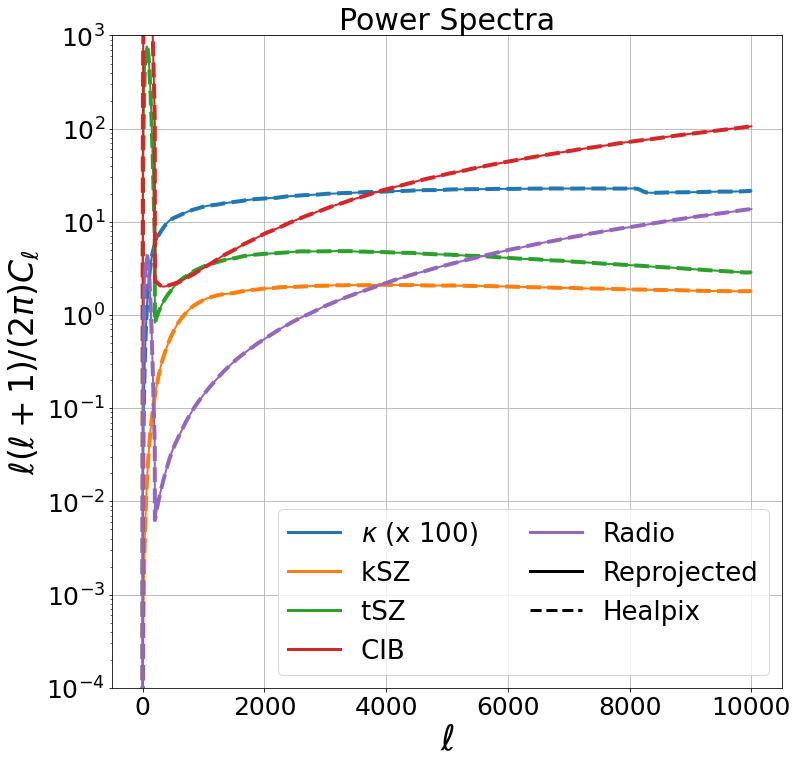

In [10]:
def key2label(key):
    storage = {"kappa":r"$  \kappa$ (x 100)",
               "ksz":"kSZ ",
               "tsz":"tSZ ",
               "ir":"CIB ",
               "rad":"Radio",
              }
    return storage[key]

flux_cut = True

plt.clf()
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
for key1 in compts:
    key2 = key1
    key = [key1, key2]
    key.sort()
    key = "x".join(key)
    multi_fact = 1e4 if key1 == "kappa" else 1
 
    color = next(ax._get_lines.prop_cycler)['color']
   
    dlbin = hdls[key]*multi_fact
    plt.plot(hdls["l"], dlbin, alpha=1, lw=4, marker="",markersize=8, color=color, ls="--")
   
    dlbin =  cdls[key]*multi_fact
    print(cdls[key]/hdls[key])
    plt.plot(hdls["l"], dlbin, alpha=1, lw=2, marker="",markersize=12, color=color, ls="-")
    
    plt.plot([],[], lw=3, label=key2label(key1), color=color)

plt.title("Power Spectra", fontsize=30)
plt.plot([],[], lw=3, marker="", ls="-", label="Reprojected",  color="k")    
plt.plot([],[], lw=3, marker="", label="Healpix", color="k", ls="--")
ax.set_ylabel(r"$\ell(\ell+1)/(2\pi )C_\ell$", fontsize=33)
ax.set_xlabel(r"$\ell$", fontsize=35)
plt.legend(fontsize=26, ncol=2)



ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='minor', labelsize=25)
#ax.axvline(x=200, ls=":", color="k")
plt.ylim(1e-4, 1e3)
ax.set_yscale("log")
ax.grid()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

('kappa', 'tsz')
kappa tsz
kappa tsz
('kappa', 'ir')
kappa ir
kappa ir
('kappa', 'rad')
kappa rad
kappa rad
('ir', 'tsz')
ir tsz
ir tsz


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value 

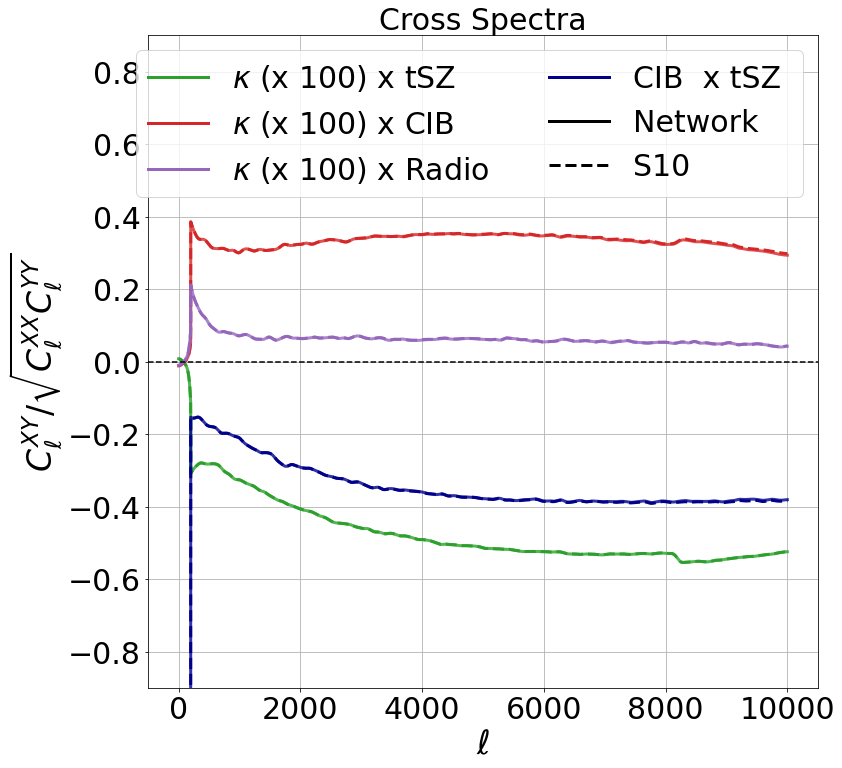

In [11]:
def get_correlation(STAT, key1, key2, postfix=""):
    print(key1, key2)
    key = [key1, key2]
    key.sort()
    key = "x".join(key)+postfix
    
    dls_x = STAT[key].copy()

    key = "x".join([key1, key1])+postfix
    dls_1 = STAT[key].copy()

    key = "x".join([key2, key2])+postfix
    dls_2 = STAT[key].copy()

    return dls_x/np.sqrt(dls_1*dls_2)

fig = plt.figure(figsize=(12,12))
ax = fig.gca()

color = next(ax._get_lines.prop_cycler)['color']
color = next(ax._get_lines.prop_cycler)['color']
for pair in [("kappa", "tsz"), ("kappa", "ir"), ("kappa", "rad"), ("ir", "tsz")]:
    print(pair)
    key1, key2 = pair

    l = cdls["l"]
    color = next(ax._get_lines.prop_cycler)['color']
    if key1 == "ir": color="darkblue"
    
    rho = get_correlation(cdls, key1, key2)
    ax.plot(l, rho, alpha=0.8,  ls="-", lw=3, marker="", markersize=10, color=color)
    rho = get_correlation(hdls, key1, key2)
    ax.plot(l, rho, alpha=3,  ls="--", lw=3, marker="", markersize=10, color=color)
    plt.plot([],[], label="{}".format(" x ".join([key2label(key1), key2label(key2)])), lw=3, color=color)


plt.plot([],[], ls="-", lw=3, label="Network", color="k", markersize=30)
plt.plot([],[], ls="--", lw=3, label="Healpix", color="k", markersize=30)
plt.title("Cross Spectra", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
plt.ylabel(r"$C_{\ell}^{XY}/\sqrt{C_{\ell}^{XX}C_{\ell}^{YY}}$", fontsize=33)
#plt.ylabel(r"$\rho$", fontsize=33)
plt.xlabel(r"$\ell$", fontsize=33)
plt.ylim(-0.9,0.9)
plt.grid()
#plt.axvline(x=200, ls=":", color="k")
plt.axhline(y=0, ls="--", color="k")
plt.legend(fontsize=30, ncol=2)
plt.show()

In [12]:
nbins = 10000

hphists = {}
chists = {}
compts = CSEHGAL.get_compts_idxes(trimmed=True)
for i, compt_idx in enumerate(compts[:]):
    compt_idx = compt_idx.split("_")[0]
    hpmap = hp/maps[compt_idx].copy()*hparea#/np.std(hpmaps[compt_idx])
    ctemp = cmaps[i].copy()*enmap.pixsizemap(shape,wcs)#/np.std(cmaps[i])
    print(compt_idx, np.max(hpmap), np.max(ctemp))

kappa 2.0062199138383794e-08 2.4345749497842458e-08
ksz 9.007761760118488e-07 1.0626907072722182e-06
tsz -8.968330795309122e-09 1.0662127888518178e-07
ir 1.7518366774522053e-05 1.7367593422012516e-05
rad 1.7788366348969952e-05 1.778836666541588e-05


In [29]:
nbins = 10000

hphists = {}
chists = {}
compts = CSEHGAL.get_compts_idxes(trimmed=True)
for i, compt_idx in enumerate(compts[:]):
    compt_idx = compt_idx.split("_")[0]
    hpmap = hpmaps[compt_idx].copy()#/np.std(hpmaps[compt_idx])
    ctemp = cmaps[i].copy()#/np.std(cmaps[i])
    hpmap *= hparea
    ctemp = ctemp*enmap.pixsizemap(shape,wcs)
    ydel = shape[0] // 9
    print(shape, ydel)
    ctemp = ctemp[ydel*4:(ydel)*5,:]
    
    hpmap /= np.std(hpmap)
    ctemp /= np.std(ctemp)
    
    hpmax = np.max(hpmap)
    cmax = np.max(ctemp)
    tmax = np.max([hpmax, cmax])
 
    hpmin = np.min(hpmap)
    cmin = np.min(ctemp)
    tmin = np.min([hpmin, cmin])
 
    print(i, compt_idx, tmin, tmax)
    
    FB = stats.FastBINNER(tmin, tmax, nbins)
    bin_center, hphist = FB.bin(hpmap)
    FB = stats.FastBINNER(tmin, tmax, nbins)
    bin_center, chist = FB.bin(ctemp.flatten())
    print(hphist-chist)
    
    hphists[compt_idx] = {}
    hphists[compt_idx]["bin_centers"] = bin_center
    hphists[compt_idx]["hist"] = hphist
    chists[compt_idx] = {}
    chists[compt_idx]["bin_centers"] = bin_center
    chists[compt_idx]["hist"] = chist

print("Done")
np.savez("/home/dwhan89/workspace/cosmikyu/data/sehgal/271120_onept_healpix_full_{}.npz".format(nbins), **hphists)
np.savez("/home/dwhan89/workspace/cosmikyu/data/sehgal/271120_onept_reprojected_full_{}.npz".format(nbins), **chists)

(21601, 43200) 2400
0 kappa -12.259580190904073 15.031939597257624
[1. 0. 0. ... 0. 0. 0.]
(21601, 43200) 2400
1 ksz -24.6909262581418 21.45914131177793
[8. 0. 0. ... 0. 0. 4.]
(21601, 43200) 2400
2 tsz -146.9958303776189 1.2335751647697328
[ 8.  0.  0. ...  0. -8. -4.]
(21601, 43200) 2400
3 ir 0.0 57.027148923607605
[2.665538e+06 8.000000e+00 9.440000e+02 ... 0.000000e+00 0.000000e+00
 0.000000e+00]
(21601, 43200) 2400
4 rad 0.0 153.74056527102303
[6.60964621e+08 3.83042300e+06 8.51039600e+06 ... 8.00000000e+00
 0.00000000e+00 8.00000000e+00]
Done


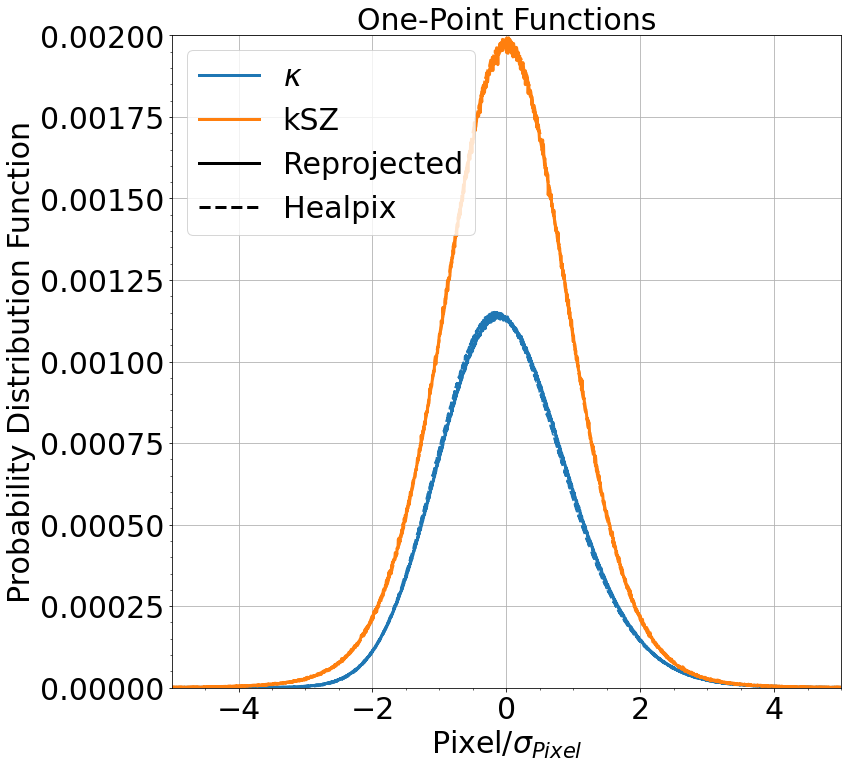

In [39]:
model =  cutils.load_data(
    "/home/dwhan89/workspace/cosmikyu/data/sehgal/271120_onept_healpix_full_{}.npz".format(nbins))
generated = cutils.load_data(
    "/home/dwhan89/workspace/cosmikyu/data/sehgal/271120_onept_reprojected_full_{}.npz".format(nbins))
def key2label(key):
    storage = {"kappa":"$\kappa $",
               "ksz":"kSZ",
               "tsz":"tSZ ",
               "ir":"CIB ",
               "rad":"Radio",
              }
    return storage[key]
nbins = 10000
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
for i, key in enumerate(compts[:2]):
    color = next(ax._get_lines.prop_cycler)['color']
    hist_generated = generated[key]['hist']
    bins_generated = generated[key]["bin_centers"]
    nsum_generated = np.sum(hist_generated)
    pdf_hist = hist_generated/nsum_generated   
    plt.plot(bins_generated, pdf_hist, alpha=1, lw=3, ls="-", color=color, label=key2label(key))
    
    hist_model = model[key]['hist']
    bins_model = model[key]["bin_centers"]
    nsum_model = np.sum(hist_model)
    pdf_model = hist_model/nsum_model
    plt.plot(bins_model, pdf_model, alpha=1, ls="--", lw=3, color=color)


plt.ylabel("Probability Distribution Function", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
plt.plot([],[], lw=3, marker="", ls="-", label="Reprojected", color="k")    
plt.plot([],[], lw=3, marker="", label="Healpix", color="k", ls="--")
plt.legend(fontsize=30)
plt.title(r"One-Point Functions", fontsize=30)
plt.xlabel(r"Pixel/$\sigma_{Pixel}$", fontsize=30)
plt.xlim(-5,5)
plt.yscale("linear")
plt.ylim(0,0.002)
plt.minorticks_on()
ax.tick_params(axis='x', which='minor', bottom=True)
plt.grid()
#plt.savefig(plot_path(f"071220_one_point_full.pdf"), bbox_inches='tight')
plt.show()

In [32]:

def cum_num_count(lbin, binned, area=4*np.pi*(180/np.pi)**2):
    cum_sum = np.cumsum(binned)
    ret = (np.ones(len(binned))*np.sum(binned)-cum_sum)/area
    return lbin, ret

2 tsz -0.0034793838788759026 4.1947128450094043e-05
-0.0034793838788759026


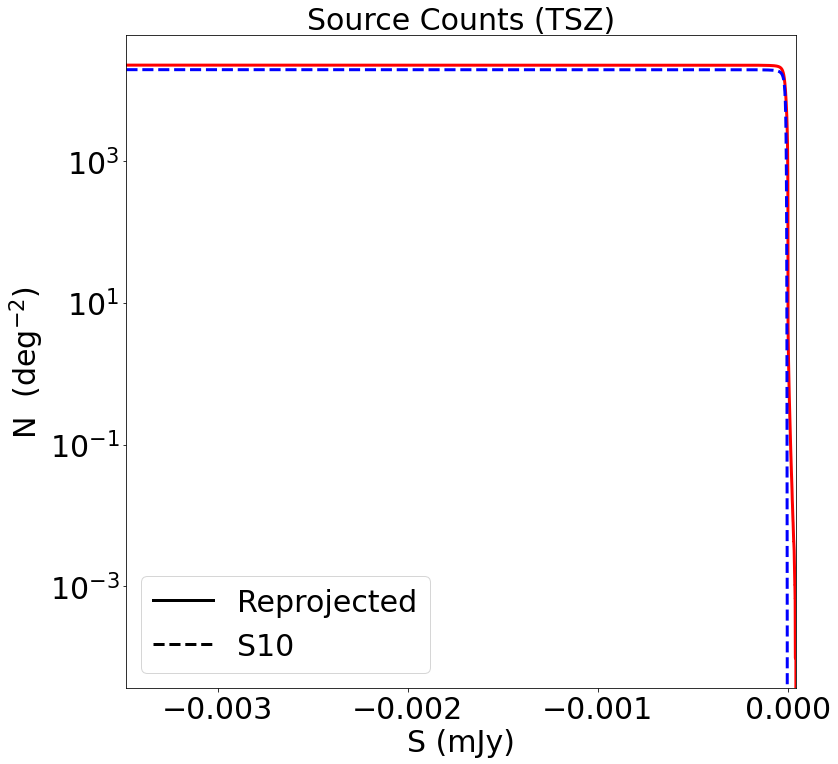

3 ir 0.0 0.006892106238174799
0.0


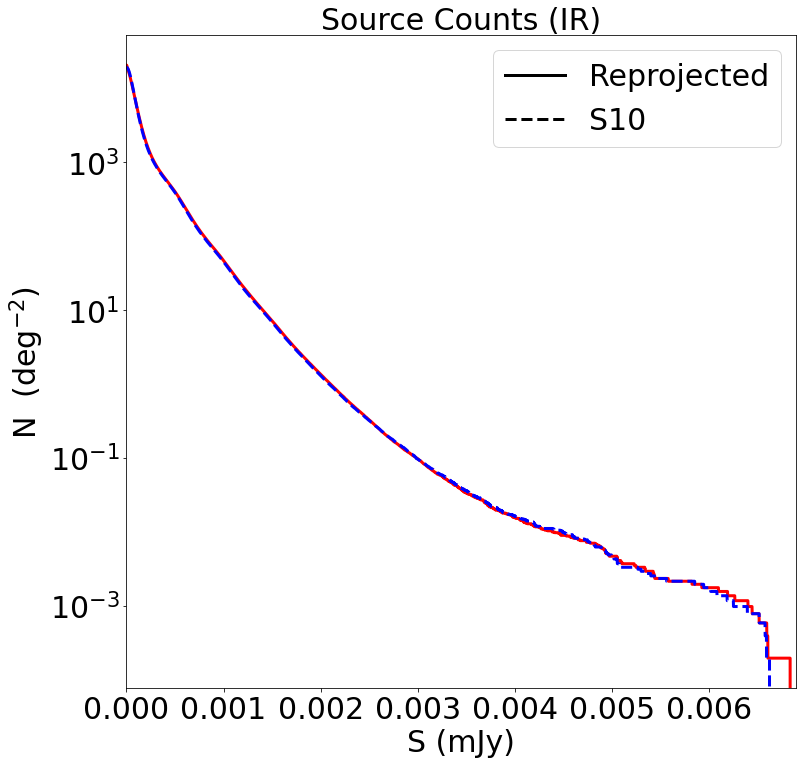

4 rad 0.0 0.006998330063505492
0.0


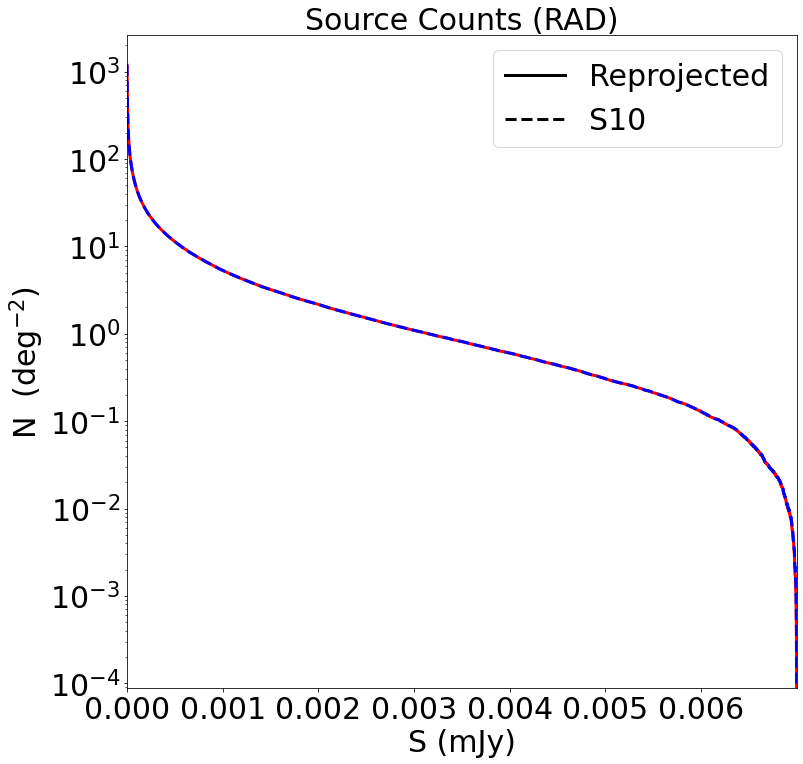

In [52]:

def key2label(key):
    storage = {"kappa":"$\kappa $",
               "ksz":"kSZ",
               "tsz":"tSZ ",
               "ir":"CIB ",
               "rad":"Radio",
              }
    return storage[key]
nbins = 1000
for i, compt_idx in enumerate(compts[:]):
    if i < 2: continue
    nbins = 10000
    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca()
    
    compt_idx = compt_idx.split("_")[0]
    hpmap = hpmaps[compt_idx].copy()/sehgal.jysr2thermo(148)*hparea
    ctemp = (cmaps[i].copy()/sehgal.jysr2thermo(148))*enmap.pixsizemap(shape,wcs)

    hpmax = np.max(hpmap)
    cmax = np.max(ctemp)
    tmax = np.max([hpmax, cmax])
 
    hpmin = np.min(hpmap)
    cmin = np.min(ctemp)
    tmin = np.min([hpmin, cmin])
 
    print(i, compt_idx, tmin, tmax)
    
    FB = stats.FastBINNER(tmin, tmax, nbins)
    bin_center, hphist = FB.bin(hpmap)
    FB = stats.FastBINNER(tmin, tmax, nbins)
    bin_center, chist = FB.bin(ctemp.flatten())
    
    _, pdf_hist = cum_num_count(bin_center, chist)
    plt.plot(bin_center, pdf_hist, alpha=1, lw=3, ls="-", color="r")
    
    _, pdf_model = cum_num_count(bin_center,hphist)
    plt.plot(bin_center, pdf_model, alpha=1, ls="--", lw=3, color="b")


    plt.ylabel(r"N  ($ {\rm{deg}}^{-2}$)", fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    plt.plot([],[], lw=3, marker="", ls="-", label="Reprojected", color="k")    
    plt.plot([],[], lw=3, marker="", label="S10", color="k", ls="--")
    plt.legend(fontsize=30)
    plt.title(f"Source Counts ({compt_idx.upper()})", fontsize=30)
    plt.xlabel(r"S (mJy)", fontsize=30)
    plt.xlim(tmin,tmax)
    print(tmin)
    plt.yscale("log")
    #plt.ylim(0,0.03)
    #plt.minorticks_on()
    #ax.tick_params(axis='x', which='minor', bottom=True)
    #plt.grid()
    #plt.savefig(plot_path(f"071220_one_point_full.pdf"), bbox_inches='tight')
    plt.show()

In [14]:
'''
## rotation test

ang1 = 40
ang2 = 60
hybrid_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/131020_hybrid_projection"
HSEHGAL = sehgal.Sehgal10Reprojected(hybrid_dir, shape, wcs)
_, halms = HSEHGAL.get_maps(60, 80, compts=["ir_pts", "rad_pts"], flux_cut=7)

cat_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues"
CSEHGAL = sehgal.Sehgal10ReprojectedFromCat(cat_dir, shape, wcs)
_, calms = CSEHGAL.get_maps(60, 80,  compts=["ir_pts", "rad_pts"], flux_cut=7)

for i, compt_idx in enumerate(["ir_pts", "rad_pts"]):
    print(i, compt_idx)
    hcl = hp.alm2cl(halms[i])
    ccl = hp.alm2cl(calms[i])
    xcl = hp.alm2cl(calms[i], halms[i])
    rho = xcl/np.sqrt(hcl*ccl)
    l = np.arange(lmax+1)

    plt.clf()
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca()
    
    plt.plot(l, hcl, lw=4, color="r",ls ="-", label="Hybrid Repro")
    plt.plot(l, ccl, lw=4, color="b",ls ="-", label="From Cat")
    plt.plot(l, xcl,  lw=4, color="g",ls ="-", label="X")

    plt.title(f"{compt_idx.upper()} Power Spectra ({ang1},{ang2})", fontsize=30)
    ax.set_xlabel(r"$\ell$", fontsize=35)
    plt.legend(fontsize=26, ncol=2)

    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.tick_params(axis='both', which='minor', labelsize=25)
    ax.set_yscale("log")
    ax.grid()
    plt.show()

    plt.clf()
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca()
    
    plt.plot(l, rho, lw=4, color="r",ls ="-", label="Hybrid X From Cat")

    plt.title(f"{compt_idx.upper()} Cross Correlation ({ang1},{ang2})", fontsize=30)
    ax.set_xlabel(r"$\ell$", fontsize=35)
    plt.legend(fontsize=26, ncol=2)
pixshapemap
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.tick_params(axis='both', which='minor', labelsize=25)
    ax.set_yscale("linear")
    ax.set_ylim(0,2)
    ax.grid()
    plt.show()
    
'''

'\n## rotation test\n\nang1 = 40\nang2 = 60\nhybrid_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/131020_hybrid_projection"\nHSEHGAL = sehgal.Sehgal10Reprojected(hybrid_dir, shape, wcs)\n_, halms = HSEHGAL.get_maps(60, 80, compts=["ir_pts", "rad_pts"], flux_cut=7)\n\ncat_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues"\nCSEHGAL = sehgal.Sehgal10ReprojectedFromCat(cat_dir, shape, wcs)\n_, calms = CSEHGAL.get_maps(60, 80,  compts=["ir_pts", "rad_pts"], flux_cut=7)\n\nfor i, compt_idx in enumerate(["ir_pts", "rad_pts"]):\n    print(i, compt_idx)\n    hcl = hp.alm2cl(halms[i])\n    ccl = hp.alm2cl(calms[i])\n    xcl = hp.alm2cl(calms[i], halms[i])\n    rho = xcl/np.sqrt(hcl*ccl)\n    l = np.arange(lmax+1)\n\n    plt.clf()\n    fig = plt.figure(figsize=(12,12))\n    ax = fig.gca()\n    \n    plt.plot(l, hcl, lw=4, color="r",ls ="-", label="Hybrid Repro")\n    plt.plot(l, ccl, lw=4, color="b",ls ="-", label="F